In [1]:
import keras
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D,UpSampling1D,MaxPooling1D,concatenate
from keras.layers import BatchNormalization
import keras.models as models
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
import tensorflow as tf
import keras.backend as K
from matplotlib import pyplot as plt
import random

import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split

import wandb
wandb.login()

2024-07-04 13:57:15.962830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lana-caldarevic1. Use `wandb login --relogin` to force relogin


True

In [2]:
def create_model(size_0, input_size, regularizer, dp):
	data_shape = input_size
	size_0=size_0
	size_1=size_0*2
	size_2=size_1*2
	kernel_size=27
	regularizer=regularizer
	dp=dp

	in_data= layers.Input(shape=(data_shape,1))
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_data)
	conv0=BatchNormalization()(conv0)
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
	conv0=BatchNormalization()(conv0)
	pool0 = MaxPooling1D(pool_size=2)(conv0)
	conv1 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
	conv1=BatchNormalization()(conv1)
	conv1_2 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
	conv1_2=BatchNormalization()(conv1_2)
	conv1_2=Dropout(dp)(conv1_2)
	pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1_2)
	conv2=BatchNormalization()(conv2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
	conv2=BatchNormalization()(conv2)
	up10 = Conv1D(size_2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv2))
	up10=BatchNormalization()(up10)
	merge10 = concatenate([conv1_2,up10], axis = 2)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	conv10=Dropout(dp)(conv10)
	up10_1 = Conv1D(size_1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv10))
	up10_1=BatchNormalization()(up10_1)
	merge10_1 = concatenate([conv0,up10_1], axis = 2)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_1)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	out_data = Conv1D(1, kernel_size, activation = 'sigmoid', padding='same')(conv10)
	model = models.Model(inputs=[in_data], outputs=[out_data])
	model.summary()
	return model

In [3]:
def create_sweep_config():
    return {
        'method': 'random',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
             'learning_rate': {
                'distribution': 'log_uniform_values',
                'min': 1e-4,
                'max': 1e-2
            },
            'regularizer': {
                'distribution': 'log_uniform_values',
                'min': 1e-4,
                'max': 1e-1
            },
            'dp': {
                'values': [0.1, 0.3, 0.5]
            },
            'start_filters': {
                'values': [4, 8, 16]
            },
            
        }
    }

In [4]:
def train(config=None):
    global best_val_loss
    
    if config:
        wandb.init(config=config, project="fantasia-hp-tuning")
    else:
        wandb.init()
        config = wandb.config
        
    lr = wandb.config.learning_rate
    regularizer = wandb.config.regularizer
    dp = wandb.config.dp
    start_filters = wandb.config.start_filters

    adm = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    input_size = 1024
    
    model = create_model(start_filters, input_size, regularizer, dp)
    
    model.compile(loss='mse', metrics=[correlation, 'mse'], optimizer=adm)
    
    def log_representations_images(epoch, logs):
        wandb.log({
            "loss": logs['loss'],
            "CC": logs['correlation'],
            "mse": logs['mse'],
            "val_loss": logs['val_loss'],
            "val_CC": logs['val_correlation'],
            "val_mse": logs['val_mse']
        })
        fig, ax = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle('Ground truth vs. Prediction')

        for row in range(2):
            train_idx = np.random.randint(0, windows_ecg_train.shape[0])
            val_idx = np.random.randint(0, windows_ecg_validation.shape[0])

            to_predict_train = np.array([windows_ecg_train[train_idx]])
            ground_truth_train = windows_resp_train[train_idx]
            prediction_train = model.predict(to_predict_train)[0]
            prediction_train_score = model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)

            to_predict_validation = np.array([windows_ecg_validation[val_idx]])
            ground_truth_validation = windows_resp_validation[val_idx]
            prediction_validation = model.predict(to_predict_validation)[0]
            prediction_validation_score = model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)

            ax[row, 0].plot(ground_truth_train, label='Ground Truth')
            ax[row, 0].plot(prediction_train, label='Prediction')
            ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f}")
            ax[row, 0].legend()

            ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
            ax[row, 1].plot(prediction_validation, label='Prediction')
            ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f}")
            ax[row, 1].legend()
    
        wandb.log({
            "predictions_visualization": wandb.Image(fig)
        }, commit=False)
        plt.close(fig)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    run_name = wandb.run.name
    checkpoint_path = f"/home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/{run_name}.weights.h5"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    print("model training starting")
    print(windows_ecg_train[:, :, :].shape)
    model.fit(
        windows_ecg_train[:, :, :], windows_resp_train[:, :, :],
        epochs=200,
        batch_size=256,
        shuffle=True,
        callbacks=[
            LambdaCallback(on_epoch_end=log_representations_images),
            early_stopping,
            cp_callback
        ],
        validation_data=(windows_ecg_validation[:, :, :], windows_resp_validation[:, :, :])
    )
    wandb.finish()

    

    return model

In [5]:
import tensorflow as tf

def correlation(x, y):
    min_y = tf.math.reduce_min(y)
    max_y = tf.math.reduce_max(y)
    r_up = tf.math.subtract(y, min_y)
    r_down = max_y - min_y
    new_y = r_up / r_down
    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.reduce_sum(tf.multiply(xm, ym))
    r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(xm)), tf.reduce_sum(tf.square(ym))))
    r = r_num / r_den
    r = tf.maximum(tf.minimum(r, 1.0), -1.0)
    
    return 1 - r


def new_mse(x,y):
	min_y=tf.math.reduce_min(y)
	max_y=tf.math.reduce_max(y)
	r_up=tf.math.subtract(y,min_y)
	r_down=max_y-min_y
	new_y=r_up/r_down
	return tf.math.reduce_mean(tf.math.squared_difference(x, new_y))


In [6]:
import wfdb
import pandas as pd
import os
import numpy as np
def load_fantasia():
    files = os.listdir("/home/lcaldarevic/workspace/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/home/lcaldarevic/workspace/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([data["ECG"], data["RESP"]])

    return data_fantasia, patients_fantasia

data, patients = load_fantasia()

In [7]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices, method='clipping'):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                # Normalize ECG using mean and std deviation
                normalized_ecg = (recrd_ecg - recrd_ecg.mean()) / recrd_ecg.std()
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))


    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [8]:
import neurokit2 as nk
sampling_rate = 250
def fill_nan_values(data):
    filled_data = {}
    for participant, signals in data.items():
        ecg_data = signals[0, :]
        resp_data = signals[1, :]

        ecg_filled = nk.signal_interpolate(ecg_data, method='linear')
        ecg_filled = nk.ecg_clean(ecg_filled, sampling_rate=sampling_rate, method="neurokit")
        
        resp_filled = nk.signal_interpolate(resp_data, method='linear')
        resp_filled = nk.rsp_clean(resp_filled, sampling_rate=sampling_rate)
        
        filled_data[participant] = np.vstack((ecg_filled, resp_filled))
    
    return filled_data

def check_for_nan(data, patients):
    for patient in patients:
        if np.isnan(data[patient]).any():
            print(f"NaN values found in patient data index: {patient}")

check_for_nan(data, patients)

data_filled = fill_nan_values(data)

check_for_nan(data_filled, patients)

NaN values found in patient data index: f2o10
NaN values found in patient data index: f2y09
NaN values found in patient data index: f2o06
NaN values found in patient data index: f2y10
NaN values found in patient data index: f2o09
NaN values found in patient data index: f2y01
NaN values found in patient data index: f2y08
NaN values found in patient data index: f2y05
NaN values found in patient data index: f2o05
NaN values found in patient data index: f2o02


In [9]:
seed = 0
train_val_patients, test_patients = train_test_split(patients, test_size=0.10, random_state=seed)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.10, random_state=seed)

sampling_rate = 250
seconds_window = 16
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data_filled, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data_filled, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data_filled, window_size, downsampled_window_size, test_patients)

(28351, 1024, 1)
(28351, 1024, 1)
(3593, 1024, 1)
(3593, 1024, 1)
(3855, 1024, 1)
(3855, 1024, 1)


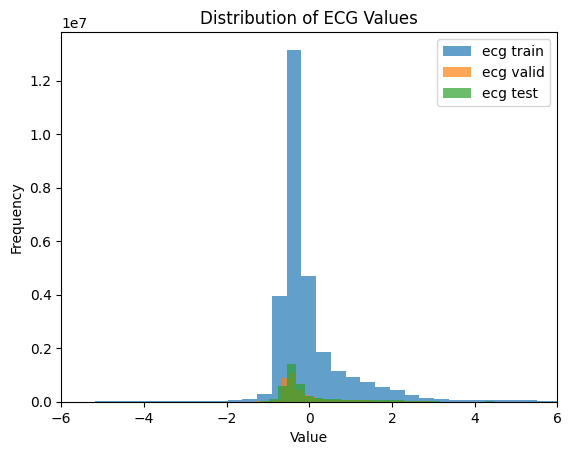

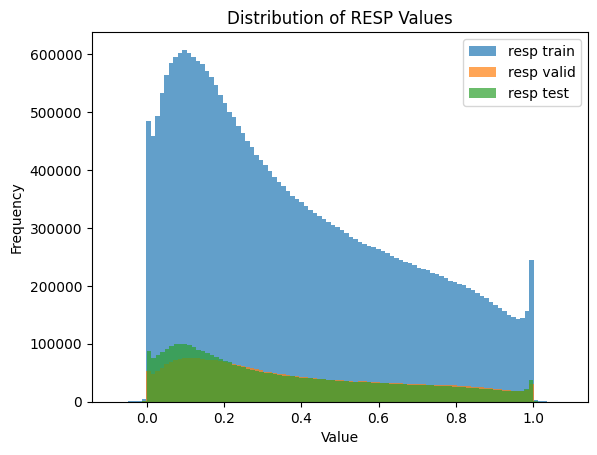

In [10]:
plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim([-6, 6]) 
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
sweep_config = create_sweep_config()
sweep_id = wandb.sweep(sweep_config, project="fantasia-hp-tuning")

wandb.agent(sweep_id, train)

500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda2.default.svc.cluster.local/validate\": read tcp 10.52.85.3:59684-\u003e10.55.247.53:80: read: connection reset by peer","path":["upsertSweep"]}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda2.default.svc.cluster.local/validate": read tcp 10.52.85.3:59684->10.55.247.53:80: read: connection reset by peer (<Response [500]>)


Create sweep with ID: kxi2y9aq
Sweep URL: https://wandb.ai/lana-caldarevic1/fantasia-hp-tuning/sweeps/kxi2y9aq


wandb: Agent Starting Run: yrkjkkx7 with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.0020545342760333305
wandb: 	regularizer: 0.05418960521015964
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2024-07-04 13:58:17.096600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-07-04 13:58:17.097291: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22198 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200


I0000 00:00:1720094301.988422 3272423 service.cc:145] XLA service 0x7ee18002b210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720094301.988472 3272423 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1720094301.988476 3272423 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-04 13:58:22.146620: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-04 13:58:22.635112: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  5/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - correlation: 0.9998 - loss: 8.4179 - mse: 0.1504

I0000 00:00:1720094313.583811 3272423 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/stepstep - correlation: 0.8630 - loss: 4.2063 - mse: 0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fresh-sweep-1.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 154ms/step - correlation: 0.8615 - loss: 4.1875 - mse: 0.1028 - val_correlation: 1.0030 - val_loss: 0.2549 - val_mse: 0.0778
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.4257 - loss: 0.1568 - mse: 0.050
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fresh-sweep-1.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.4252 - loss: 0.1557 - mse: 0.0505 - val_correlation: 1.0028 - val_loss: 0.1004 - val_mse: 0.0766
Epoch 3/200
1/1 ━━━━━━━━━━━━━━

CC,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▇▅▃▂▁▁▁▁▃▁▂▁▂▂▁
val_loss,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
val_mse,▆▆▆▆▇█▄▁▄▃▃▄▃▂▁▂▄▃
CC,0.29061
loss,0.04351
mse,0.03756
val_CC,0.44153
val_loss,0.06944


wandb: Agent Starting Run: q5mh6m3f with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.0002129604024191233
wandb: 	regularizer: 0.011504082305938149
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/steptep - correlation: 0.9963 - loss: 1.7787 - mse: 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/rose-sweep-2.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - correlation: 0.9961 - loss: 1.7772 - mse: 0.1300 - val_correlation: 0.9968 - val_loss: 1.2832 - val_mse: 0.0822
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.9446 - loss: 1.1775 - mse: 0.087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/rose-sweep-2.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.9443 - loss: 1.1747 - mse: 0.0874 - val_correlation: 0.9829 - val_loss: 0.875

CC,██▇▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇▅▄▄▅▆▄▅▄▄▄▄▃▄▃▃▂▃▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▂▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▇▇▆▆▆▆███▇▆▅▅▇▄▄▅▄▃▄▄▄▄▃▃▂▃▂▂▃▃▁▂▃▂▃▃▁▁▂
CC,0.19294
loss,0.02935
mse,0.02636
val_CC,0.37234
val_loss,0.05136


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6e2fd1nt with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.00011957221329214148
wandb: 	regularizer: 0.0004565742049863685
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/stepstep - correlation: 0.8595 - loss: 0.3889 - mse: 0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/dauntless-sweep-3.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 168ms/step - correlation: 0.8582 - loss: 0.3886 - mse: 0.1086 - val_correlation: 0.9416 - val_loss: 0.6573 - val_mse: 0.4207
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.4515 - loss: 0.2807 - mse: 0.057
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/dauntless-sweep-3.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.4513 - loss: 0.2805 - mse: 0.0572 - val_correlation: 0.4567 - val_

CC,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,█▂▃▃▃▂▂▂▁▂▁▂▂▁▁▂▁▁▂▁▁▂▁▂▁▁▂▁▂▁▂▁▂▂▂▃▂▂▁▂
val_loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CC,0.1385
loss,0.02777
mse,0.0195
val_CC,0.4845
val_loss,0.06816


wandb: Agent Starting Run: l6qzji2g with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.002782614438960153
wandb: 	regularizer: 0.00048657118927887273
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/steptep - correlation: 0.7039 - loss: 0.1349 - mse: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/devoted-sweep-4.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - correlation: 0.7025 - loss: 0.1346 - mse: 0.0810 - val_correlation: 0.5346 - val_loss: 0.0764 - val_mse: 0.0624
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.3452 - loss: 0.0547 - mse: 0.043
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/devoted-sweep-4.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - correlation: 0.3448 - loss: 0.0546 - mse: 0.0431 - val_correlation: 0.8701 - val_loss:

CC,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,▃██▇▆▄▃▃▂▁▁▁▄▂▂▃▃▃▄▂▅▃
val_loss,▅▇█▆▅▅▃▄▂▂▁▁▄▂▂▂▂▂▃▂▅▂
val_mse,▄▇█▆▅▅▃▄▂▂▁▁▄▂▂▃▂▂▃▂▅▃
CC,0.23608
loss,0.03472
mse,0.03148
val_CC,0.49309
val_loss,0.0602


wandb: Agent Starting Run: og3lxgjt with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.00014230501096431958
wandb: 	regularizer: 0.012850254423015982
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/steptep - correlation: 0.9859 - loss: 2.0071 - mse: 0.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fanciful-sweep-5.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - correlation: 0.9859 - loss: 2.0059 - mse: 0.1293 - val_correlation: 0.9712 - val_loss: 1.6036 - val_mse: 0.0914
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.9566 - loss: 1.5107 - mse: 0.096
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fanciful-sweep-5.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.9563 - loss: 1.5080 - mse: 0.0966 - val_correlation: 0.9676 - val_los

CC,██▇▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▅▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▁▂▁▂▂▁▁▁▁▁▂▂▂▂▁▁▂▂▁▂▂
val_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▆▆▆▆▆▄▃▄▄▄▄▄▄▅▅▃▄▃▂▃▂▂▄▂▂▁▁▁▂▃▂▂▁▂▃▂▁▂▃
CC,0.19096
loss,0.02877
mse,0.02611
val_CC,0.44325
val_loss,0.06138


wandb: Agent Starting Run: qyo08s9w with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.0001944394776866821
wandb: 	regularizer: 0.00012291184721436652
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/steptep - correlation: 0.9729 - loss: 0.1311 - mse: 0.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/youthful-sweep-6.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - correlation: 0.9728 - loss: 0.1309 - mse: 0.1113 - val_correlation: 0.9738 - val_loss: 0.2039 - val_mse: 0.1850
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.8147 - loss: 0.1009 - mse: 0.082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/youthful-sweep-6.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.8127 - loss: 0.1007 - mse: 0.0822 - val_correlation: 0.6555 - val_los

CC,█▆▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,█▄▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
CC,0.2046
loss,0.03206
mse,0.02774
val_CC,0.3573
val_loss,0.04997


wandb: Agent Starting Run: 2l3uqh9w with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.0031954131151042614
wandb: 	regularizer: 0.0006247674171570403
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/steptep - correlation: 0.7237 - loss: 0.1382 - mse: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/glorious-sweep-7.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - correlation: 0.7222 - loss: 0.1378 - mse: 0.0800 - val_correlation: 0.7529 - val_loss: 0.0863 - val_mse: 0.0752
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.3536 - loss: 0.0534 - mse: 0.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/glorious-sweep-7.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.3533 - loss: 0.0534 - mse: 0.0440 - val_correlation: 0.8041 - val_los

CC,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,▇▇█▇▆▄▃▄▅▄▃▄▄▁▃▁▃▃▂▅▃▃▂▂
val_loss,▇▆▆█▇▄▄▅▅▃▃▅▅▁▃▁▃▂▂▅▃▃▃▂
val_mse,▆▆▆█▇▄▄▅▆▄▃▅▅▁▃▁▃▂▂▅▃▃▃▂
CC,0.24142
loss,0.03592
mse,0.03208
val_CC,0.4485
val_loss,0.05837


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kqsmuk3w with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.00014032849127232436
wandb: 	regularizer: 0.011794179716580972
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/steptep - correlation: 0.9574 - loss: 6.7394 - mse: 0.13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/rare-sweep-8.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - correlation: 0.9569 - loss: 6.7320 - mse: 0.1298 - val_correlation: 0.9480 - val_loss: 4.4218 - val_mse: 0.0784
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.7009 - loss: 3.9118 - mse: 0.075
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/rare-sweep-8.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.7004 - loss: 3.9078 - mse: 0.0757 - val_correlation: 0.7739 - val_loss: 2.667

CC,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,█▆▅▅▃▄▃▃▄▂▂▃▃▄▄▃▃▄▄▂▅▂▃▂▃▃▂▂▁▂▁▁▁▃▁▃▂▁▂▂
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▆▆█▇▅▆▅▆▅▂▃▄▄▄▄▅▄▅▄▂▆▃▄▂▃▃▁▂▁▂▂▁▁▃▁▃▂▁▂▂
CC,0.16101
loss,0.02622
mse,0.02238
val_CC,0.42487
val_loss,0.05536


wandb: Agent Starting Run: v05438z0 with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.0035760553064012805
wandb: 	regularizer: 0.05157543955092645
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/steptep - correlation: 0.7488 - loss: 7.9467 - mse: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/lucky-sweep-9.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - correlation: 0.7479 - loss: 7.9006 - mse: 0.0826 - val_correlation: 1.0028 - val_loss: 0.2397 - val_mse: 0.0762
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.6105 - loss: 0.2005 - mse: 0.065
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/lucky-sweep-9.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.6105 - loss: 0.2003 - mse: 0.0652 - val_correlation: 0.9835 - val_loss: 0.2

CC,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▇▅▂▃▃▃▃▂▂▃▃▁▂▂▂▃▂▂▂▃▂▂▂▂▁▂▁▁▁▂▁▂▂▂▁▂▂
val_loss,██▄▃▃▃▃▂▂▃▂▂▂▂▁▂▂▃▂▂▁▁▂▁▂▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁
val_mse,▄▄▄▅▄▅▂▄▄▄▃▄▃▃▂▃▃█▄▃▃▂▃▂▃▃▃▂▃▂▂▁▂▂▃▃▂▂▂▂
CC,0.37012
loss,0.05001
mse,0.04556
val_CC,0.49879
val_loss,0.06352


wandb: Agent Starting Run: uasouszx with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.0003999140144441036
wandb: 	regularizer: 0.022459629294628657
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/steptep - correlation: 0.9713 - loss: 3.1317 - mse: 0.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/solar-sweep-10.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - correlation: 0.9710 - loss: 3.1270 - mse: 0.1216 - val_correlation: 0.9797 - val_loss: 1.7174 - val_mse: 0.0771
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.7520 - loss: 1.4529 - mse: 0.074
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/solar-sweep-10.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.7517 - loss: 1.4509 - mse: 0.0743 - val_correlation: 1.0081 - val_loss: 0

CC,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▆▅▅▅▇▆▇▆▅▄▅▃▄▄▄▄▃▃▃▂▃▄▂▁▃▂▂▁▂▂▂▂▃▂▄▃▃
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▇▇▇█▇▇▇▇▆▆▆▅▅▆▅▅█▅▆▇▄█▄▄▅▃▁▅▃▃▁▅▃▃▂▃▃▅▄▄
CC,0.21431
loss,0.03216
mse,0.02891
val_CC,0.55573
val_loss,0.0683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rb2x41no with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.004001138415640287
wandb: 	regularizer: 0.04993234619677724
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/stepstep - correlation: 0.7474 - loss: 4.3784 - mse: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/chocolate-sweep-11.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - correlation: 0.7461 - loss: 4.3536 - mse: 0.0848 - val_correlation: 1.0047 - val_loss: 0.1452 - val_mse: 0.0760
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.4434 - loss: 0.1017 - mse: 0.052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/chocolate-sweep-11.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - correlation: 0.4434 - loss: 0.1016 - mse: 0.0524 - val_correlation: 1.0044 - va

CC,█▄▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▄▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▇▅▂▄▃▄▄▃▃▃▂▁▁▂▃▂▄▁▃▃▃▃▂▁▂▂▄▂
val_loss,▆▄▄▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▁▃▁▃▂▂▂▂▁▁▂█▂
val_mse,▂▂▂▃▂▁▂▂▂▂▂▂▂▂▂▁▂▂▁▃▁▃▂▂▂▂▁▁▃█▂
CC,0.34035
loss,0.0518
mse,0.04268
val_CC,0.45892
val_loss,0.07055


wandb: Agent Starting Run: d18j76u6 with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.000299237659901307
wandb: 	regularizer: 0.05300549038418816
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/steptep - correlation: 0.9716 - loss: 14.2116 - mse: 0.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/lemon-sweep-12.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - correlation: 0.9711 - loss: 14.1894 - mse: 0.1266 - val_correlation: 0.9799 - val_loss: 7.5796 - val_mse: 0.0826
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.8292 - loss: 6.3676 - mse: 0.078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/lemon-sweep-12.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - correlation: 0.8289 - loss: 6.3587 - mse: 0.0785 - val_correlation: 0.9713 - val_loss:

CC,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇▇▇███▇▇▆▆▅▅▅▄▅▄▆▅▆▆▅▄▆▄▂▂▁▂▁▂▁▁▂▁▁▂▂▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▅▆▆▅▆▆▇█▅▆▄▅▅▅▄▃▄▄▄▄▄▅▄▃▅▄▂▂▁▂▁▂▂▁▂▁▁▂▂▁
CC,0.21215
loss,0.0331
mse,0.02865
val_CC,0.3647
val_loss,0.05173


wandb: Agent Starting Run: e3lbcfkp with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.0001858255393634628
wandb: 	regularizer: 0.005880746883165652
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/steptep - correlation: 0.9835 - loss: 1.0067 - mse: 0.12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/bright-sweep-13.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - correlation: 0.9835 - loss: 1.0060 - mse: 0.1269 - val_correlation: 0.9987 - val_loss: 0.7655 - val_mse: 0.0859
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.9842 - loss: 0.7135 - mse: 0.087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/bright-sweep-13.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.9842 - loss: 0.7121 - mse: 0.0873 - val_correlation: 0.9958 - val_loss:

CC,███▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▆▅▅▃▄▄▃▃▃▄▃▄▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂
val_loss,█▆▅▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▆▅▅▅▆▇▆▆█▆▆▆▇▆█▅▆▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▂▂▁▂▁▂▂
CC,0.21392
loss,0.03148
mse,0.02887
val_CC,0.50266
val_loss,0.05985


wandb: Agent Starting Run: 60wr2zof with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.004551776511192604
wandb: 	regularizer: 0.0001450831250885011
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/steptep - correlation: 0.7119 - loss: 0.0968 - mse: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/jumping-sweep-14.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - correlation: 0.7103 - loss: 0.0966 - mse: 0.0788 - val_correlation: 0.5955 - val_loss: 0.0744 - val_mse: 0.0673
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.3348 - loss: 0.0484 - mse: 0.042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/jumping-sweep-14.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.3344 - loss: 0.0484 - mse: 0.0421 - val_correlation: 0.5478 - val_los

CC,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,█▆█▇▅▄▄▂▁▂▃▂▂▅▄▃▁▂▂▄▂▂▁▃▁▅▃▆▃▄▃▂▄
val_loss,█▇█▆█▆▅▂▂▃▃▂▂▅▄▃▁▃▂▄▂▂▁▂▂▄▂▆▃▄▂▃▄
val_mse,▇▆█▆█▆▅▂▂▃▃▂▂▅▅▃▁▃▂▄▂▂▁▃▂▄▂▆▃▄▃▃▅
CC,0.22505
loss,0.03334
mse,0.03019
val_CC,0.4689
val_loss,0.05955


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6d5058gj with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.0005879048361890629
wandb: 	regularizer: 0.0014781518924649414
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/steptep - correlation: 0.6347 - loss: 0.7331 - mse: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/cerulean-sweep-15.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - correlation: 0.6332 - loss: 0.7311 - mse: 0.0781 - val_correlation: 0.7229 - val_loss: 0.2566 - val_mse: 0.0787
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.2728 - loss: 0.1723 - mse: 0.035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/cerulean-sweep-15.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.2726 - loss: 0.1720 - mse: 0.0358 - val_correlation: 0.9392 - val_l

CC,█▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,▅█▇▆█▇▆▆▄▅▆▄▄▃▃▃▃▄▃▃▅▃▂▅▁▃▃▄▂▃▂▁▄▂▂
val_loss,█▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▂
val_mse,▆▆▅▅▅▆▇█▇▆▅▆▆▅▄▃▅▄▅▃▅▃▄▅▁▄▄▄▂▃▂▁▄▂▄
CC,0.16801
loss,0.02786
mse,0.02329
val_CC,0.4874
val_loss,0.0689


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ualfdtsy with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.009246207853149148
wandb: 	regularizer: 0.010611157016209342
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/steptep - correlation: 0.7146 - loss: 0.6808 - mse: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/unique-sweep-16.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - correlation: 0.7137 - loss: 0.6772 - mse: 0.0758 - val_correlation: 0.9778 - val_loss: 0.1071 - val_mse: 0.0767
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.5350 - loss: 0.1028 - mse: 0.060
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/unique-sweep-16.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - correlation: 0.5347 - loss: 0.1028 - mse: 0.0601 - val_correlation: 0.8354 - val_loss:

CC,█▅▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,█▆▄▄▅▂▁▁▂▁▁▃▁▂▁▂▂▁▃▂▁▂▁▂▂▃▁▁▁▂▂▂▃▃▂▂▂
val_loss,▅▆▄▄▃▂▁▂▂▁▂▂▁▂▁▃▃▃▂▂▁█▁▂▂▃▁▂▁▂▂▁▃▂▁▁▂
val_mse,▃▃▃▃▃▂▁▂▂▁▂▂▁▃▁▃▃▃▃▂▁█▁▂▃▃▁▂▁▂▂▁▃▂▁▁▂
CC,0.3485
loss,0.04897
mse,0.04349
val_CC,0.42182
val_loss,0.06767


wandb: Agent Starting Run: g0qyf7h3 with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.0011151375267614515
wandb: 	regularizer: 0.008744579417340878
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/steptep - correlation: 0.8167 - loss: 1.6309 - mse: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/breezy-sweep-17.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - correlation: 0.8151 - loss: 1.6247 - mse: 0.0963 - val_correlation: 0.9794 - val_loss: 0.2430 - val_mse: 0.0755
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.3553 - loss: 0.1602 - mse: 0.044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/breezy-sweep-17.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - correlation: 0.3551 - loss: 0.1599 - mse: 0.0443 - val_correlation: 0.9971 - val_loss:

CC,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,████▇▇▇▄▄▃▃▂▃▄▁▃▁▂▁▂▂▃▃▂▂▁▁▃▃▃▃▃▃▃▂▃
val_loss,█▃▃▂▂▂▂▂▃▁▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mse,▅▆▇▆▆▇▇▅█▃▃▄▃▄▃▃▁▂▁▃▂▃▃▂▃▁▁▃▃▂▃▃▃▂▂▃
CC,0.21834
loss,0.03443
mse,0.02939
val_CC,0.53762
val_loss,0.06697


wandb: Agent Starting Run: z405l3iu with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.00513109091252042
wandb: 	regularizer: 0.000306725433553038
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/steptep - correlation: 0.5692 - loss: 0.1701 - mse: 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/exalted-sweep-18.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - correlation: 0.5677 - loss: 0.1695 - mse: 0.0681 - val_correlation: 0.8654 - val_loss: 0.0886 - val_mse: 0.0738
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.2592 - loss: 0.0475 - mse: 0.034
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/exalted-sweep-18.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.2592 - loss: 0.0475 - mse: 0.0342 - val_correlation: 0.9946 - val_los

CC,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_CC,▇█▇▆▇▂▃▂▁▂▂▂▃▄▃▂▃▃▁
val_loss,▅▅▅▅▅█▃▂▁▁▂▂▂▅▂▂▂▂▁
val_mse,▄▅▅▅▅█▃▂▁▁▂▂▃▆▃▂▃▃▁
CC,0.20463
loss,0.033
mse,0.02778
val_CC,0.42409
val_loss,0.05748


wandb: Agent Starting Run: c6tf82sf with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.001874684976699877
wandb: 	regularizer: 0.0017128950767412005
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/steptep - correlation: 0.6514 - loss: 0.3537 - mse: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/gentle-sweep-19.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - correlation: 0.6497 - loss: 0.3524 - mse: 0.0769 - val_correlation: 1.0041 - val_loss: 0.1080 - val_mse: 0.0787
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.2682 - loss: 0.0580 - mse: 0.035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/gentle-sweep-19.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - correlation: 0.2681 - loss: 0.0579 - mse: 0.0350 - val_correlation: 0.9955 - val_loss:

CC,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▆▆▄█▃▁▃▁▂▁▁▃▂▂▃▂▃▂▂▂
val_loss,█▆▆▅▅▄▇▄▂▃▁▃▁▁▃▁▂▃▂▂▁▂▂
val_mse,▆▆▇▅▅▅█▄▂▄▁▃▁▂▄▂▃▃▃▃▁▃▂
CC,0.20175
loss,0.03234
mse,0.02745
val_CC,0.47813
val_loss,0.0595


wandb: Agent Starting Run: 2mxirlw2 with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.000629187513815135
wandb: 	regularizer: 0.015547787162173874
wandb: 	start_filters: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 4)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 4)   │         16 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 4)   │        436 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 4)   │         16 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 4)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 8)    │        872 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 8)    │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 8)    │         32 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 8)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 8)    │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 16)   │      3,472 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 16)   │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 16)   │        528 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,409 (91.44 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 208 (832.00 B)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/steptep - correlation: 0.9899 - loss: 1.9739 - mse: 0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/eager-sweep-20.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - correlation: 0.9898 - loss: 1.9697 - mse: 0.1009 - val_correlation: 1.0032 - val_loss: 0.7936 - val_mse: 0.0755
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.8436 - loss: 0.6349 - mse: 0.073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/eager-sweep-20.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - correlation: 0.8402 - loss: 0.6315 - mse: 0.0732 - val_correlation: 0.9985 - val_loss: 0

CC,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇█▇▇▆▆▆▄▃▂▃▃▂▁▂▁▂▂▁▂▂▁▂▁▂▂▃▁▂▂▁▂
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▇▇██▇▇█▇█▆▆▄▆▄▄▁▂▂▃▃▂▃▃▁▄▂▂▄▄▂▃▃▂▂
CC,0.2305
loss,0.03447
mse,0.03081
val_CC,0.44531
val_loss,0.05611


wandb: Agent Starting Run: fvyskbja with config:
wandb: 	dp: 0.1
wandb: 	learning_rate: 0.00304686794242121
wandb: 	regularizer: 0.00012558164592426223
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/steptep - correlation: 0.5150 - loss: 0.1257 - mse: 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fallen-sweep-21.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - correlation: 0.5138 - loss: 0.1254 - mse: 0.0644 - val_correlation: 0.6627 - val_loss: 0.0923 - val_mse: 0.0732
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.2350 - loss: 0.0476 - mse: 0.031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/fallen-sweep-21.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.2350 - loss: 0.0475 - mse: 0.0314 - val_correlation: 0.7933 - val_loss:

CC,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
loss,█▃▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁
mse,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁
val_CC,▅▇▆▇█▄▃▆▃▂▃▅▁▃▃▂▃▂▄▃▄▃▃
val_loss,█▇▇▆▆▄▅█▆▂▂▃▁▂▂▂▁▁▃▂▃▂▂
val_mse,▅▆▇▆▆▄▅█▆▁▂▄▁▃▂▂▂▂▃▂▃▃▃
CC,0.17847
loss,0.02947
mse,0.0246
val_CC,0.5712
val_loss,0.06677


wandb: Agent Starting Run: mt0g30jc with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.006165407928311601
wandb: 	regularizer: 0.022551324742301863
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/steptep - correlation: 0.7701 - loss: 2.7389 - mse: 0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/golden-sweep-22.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - correlation: 0.7698 - loss: 2.7230 - mse: 0.0813 - val_correlation: 1.0026 - val_loss: 0.1587 - val_mse: 0.0759
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.6859 - loss: 0.1495 - mse: 0.068
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/golden-sweep-22.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.6862 - loss: 0.1495 - mse: 0.0686 - val_correlation: 0.9810 - val_loss:

CC,██▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▇▇▇▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇▆▇▇▃▄▄▁▃▃▂▂▄▂▁▂▁▃▁▂▂▃▃▂▁▂▁▁▁▁▂▃▂▂▃
val_loss,▇█▇▆▅▆▅▄▄▂▃▂▃▃▃▃▁▂▁▃▁▂▂▂▂▁▁▁▂▄▂▂▁▂▁▁▂
val_mse,▄▄▄▄▅▄▃▃▄▂▃▂▃▃▄▃▁▃▁▅▂▄▃▃▂▂▁▂▃█▃▃▂▃▂▂▄
CC,0.35043
loss,0.0482
mse,0.04364
val_CC,0.59398
val_loss,0.07711


wandb: Agent Starting Run: 58clhonn with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.003891070109888058
wandb: 	regularizer: 0.0005753674378886097
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/steptep - correlation: 0.5814 - loss: 0.1561 - mse: 0.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/peachy-sweep-23.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - correlation: 0.5801 - loss: 0.1556 - mse: 0.0690 - val_correlation: 0.9767 - val_loss: 0.0989 - val_mse: 0.0857
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.2833 - loss: 0.0486 - mse: 0.036
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/peachy-sweep-23.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - correlation: 0.2832 - loss: 0.0486 - mse: 0.0368 - val_correlation: 0.9740 - val_loss:

CC,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,███▆▃▂▂▂▃▃▁▁▂▁▂▂▃▂▂▃▂▃▃▁▂▄▂▂▂▃▁▃▁▁▂▁▂▁▂▃
val_loss,█▆▅▆▅▅▃▂▃▄▂▂▃▂▃▂▃▂▃▂▃▃▄▁▃▄▃▃▂▃▁▃▁▁▃▁▂▁▂▂
val_mse,█▇▆▆▅▆▃▂▃▄▂▂▄▂▃▂▄▂▃▃▄▃▅▁▃▅▄▃▂▃▁▃▁▁▃▁▂▂▂▃
CC,0.2055
loss,0.03233
mse,0.02788
val_CC,0.60606
val_loss,0.06632


wandb: Agent Starting Run: acms9ntg with config:
wandb: 	dp: 0.3
wandb: 	learning_rate: 0.007442957514163434
wandb: 	regularizer: 0.000336933918305226
wandb: 	start_filters: 16
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 16)  │        448 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 16)  │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 16)  │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 16)  │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 16)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 32)   │     13,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 32)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 64)   │     55,360 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 64)   │    110,656 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 365,697 (1.40 MB)

 Trainable params: 364,865 (1.39 MB)

 Non-trainable params: 832 (3.25 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/steptep - correlation: 0.6223 - loss: 0.1694 - mse: 0.07
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/deep-sweep-24.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - correlation: 0.6209 - loss: 0.1688 - mse: 0.0705 - val_correlation: 0.9452 - val_loss: 0.0911 - val_mse: 0.0772
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/stepstep - correlation: 0.3105 - loss: 0.0561 - mse: 0.040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/deep-sweep-24.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - correlation: 0.3103 - loss: 0.0561 - mse: 0.0400 - val_correlation: 0.9390 - val_loss: 0.0

CC,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇▇▄▂▃▂▃▃▃▃▂▃▂▂▂▃▁▂▂▁▂▃▂▂▂▂▂
val_loss,▇▆▇█▄▄▄▃▄▃▃▂▃▅▂▂▂▃▁▂▂▁▂▃▃▂▁▁▂
val_mse,▇▇█▇▃▃▅▃▃▃▄▃▃▇▂▃▂▄▁▂▃▁▃▄▃▂▂▁▃
CC,0.22569
loss,0.03515
mse,0.03027
val_CC,0.48791
val_loss,0.06241


wandb: Agent Starting Run: ptt3fqdt with config:
wandb: 	dp: 0.5
wandb: 	learning_rate: 0.0004534926139518253
wandb: 	regularizer: 0.0001251519381970329
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(28351, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/steptep - correlation: 0.8106 - loss: 0.1371 - mse: 0.09
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/peachy-sweep-25.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - correlation: 0.8093 - loss: 0.1369 - mse: 0.0984 - val_correlation: 0.8778 - val_loss: 0.4107 - val_mse: 0.3776
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepstep - correlation: 0.4320 - loss: 0.0830 - mse: 0.051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 2: saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/peachy-sweep-25.weights.h5
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - correlation: 0.4318 - loss: 0.0830 - mse: 0.0514 - val_correlation: 0.4672 - val_loss:

good result: https://wandb.ai/lana-caldarevic1/fantasia-hp-tuning/runs/lxl3x66m/workspace?nw=nwuserlanacaldarevic1